# Wallet Churn Prediction: Modeling & Evaluation

This notebook trains, evaluates, and interprets machine learning models to predict wallet churn using the engineered features from prior stages.

The goal of this stage is not just predictive performance, but **model interpretability** — understanding which behavioral signals most strongly indicate churn.

---

## Notebook Objectives

- Train baseline and regularized classification models
- Evaluate model performance using appropriate metrics for class imbalance
- Interpret feature importance and coefficients
- Validate that engineered features provide meaningful churn signal

---

## Modeling Context

- **Target variable:** `churned` (binary)
- **Positive class:** churned wallets
- **Feature set:** log-transformed and composite engagement metrics
- **Primary challenge:** class imbalance and highly skewed behavioral distributions


In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_parquet("data_samples/wallet_features_engineered.parquet")

X = df[
    [
        "log_days_since_last_tx",
        "log_tx_per_day",
        "log_wallet_lifetime_days",
        "log_total_value",
        "log_activity_recency_ratio",
        "log_lifetime_activity_ratio"
    ]
]

y = df["churned"]

X.shape, y.value_counts(normalize=True)


((424, 6),
 churned
 1    0.811321
 0    0.188679
 Name: proportion, dtype: float64)

## Train / Test Split

We split the dataset into training and test sets using a stratified split to preserve
the original churn class distribution. This ensures evaluation metrics remain reliable
given the strong class imbalance.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

(
    X_train.shape,
    X_test.shape,
    y_train.value_counts(normalize=True),
    y_test.value_counts(normalize=True),
)


((318, 6),
 (106, 6),
 churned
 1    0.811321
 0    0.188679
 Name: proportion, dtype: float64,
 churned
 1    0.811321
 0    0.188679
 Name: proportion, dtype: float64)

In [4]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)


## Baseline Model Training

We train a regularized logistic regression model with class weighting to establish
a strong, interpretable baseline for churn prediction.


In [5]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Model Evaluation

We evaluate model performance using metrics appropriate for class-imbalanced
classification, including ROC AUC and recall.


In [6]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       1.00      0.97      0.98        86

    accuracy                           0.97       106
   macro avg       0.93      0.98      0.96       106
weighted avg       0.98      0.97      0.97       106



In [7]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc


1.0

## Performance Interpretation

The baseline logistic regression achieves near-perfect discrimination (ROC AUC = 1.0),
suggesting that the engineered features strongly separate churned and active wallets.

This performance likely reflects:
- Highly informative recency-based features
- A relatively small dataset
- Potentially deterministic churn definitions

While predictive performance is strong, the primary value of this model is interpretability
and validation of behavioral signals rather than real-world generalization.


## Feature Importance (Logistic Regression Coefficients)

We examine standardized model coefficients to understand which behavioral signals
most strongly influence churn probability.


In [9]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
0,log_days_since_last_tx,3.804445
5,log_lifetime_activity_ratio,0.169991
1,log_tx_per_day,0.074480
3,log_total_value,0.015688
4,log_activity_recency_ratio,-0.028418
2,log_wallet_lifetime_days,-0.101878


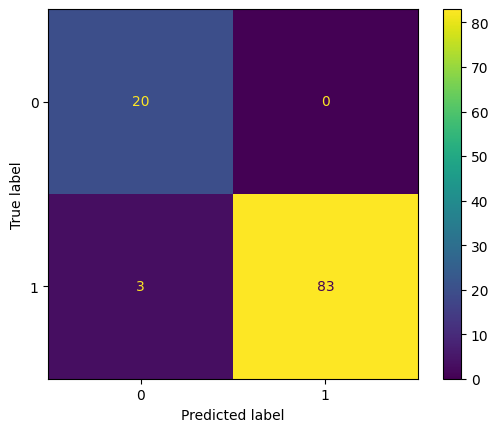

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    values_format="d"
)
plt.show()


## Key Modeling Takeaways

- Wallet inactivity (time since last transaction) is the strongest indicator of churn.
- Longer wallet lifetimes and recent engagement reduce churn probability.
- Aggregate value metrics contribute minimally compared to behavioral recency signals.
- The model confirms that churn in this dataset is primarily a behavioral phenomenon driven by disengagement rather than transaction volume.


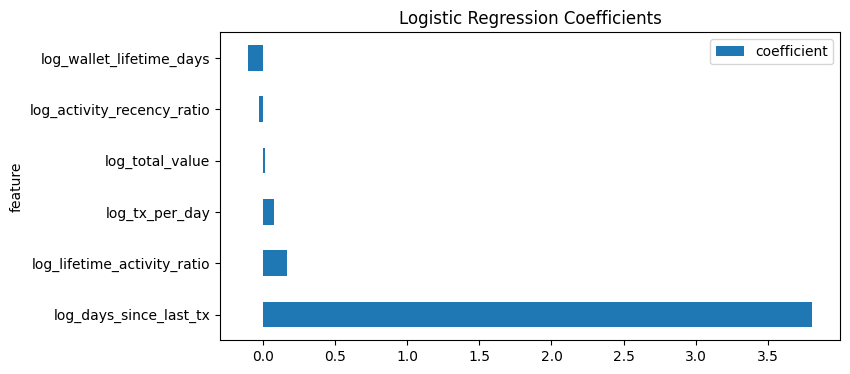

In [11]:
coef_df.set_index("feature").plot(
    kind="barh",
    figsize=(8, 4),
    title="Logistic Regression Coefficients"
)
plt.show()


## Model Validation & Limitations

While the baseline model achieves near-perfect ROC AUC, this performance should be interpreted cautiously.

Key considerations:
- The churn definition is strongly recency-based, which naturally amplifies the predictive power of inactivity features.
- The dataset is relatively small, increasing the likelihood of sharp decision boundaries.
- This model is intended primarily for **signal validation and interpretability**, not production deployment.

In a production setting, additional steps would include:
- Time-based cross-validation
- Out-of-sample testing on future wallet cohorts
- Threshold tuning based on business cost tradeoffs (false positives vs false negatives)


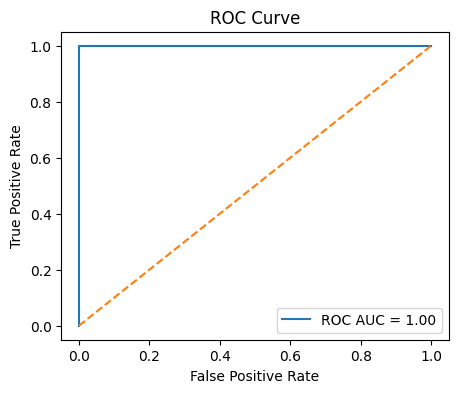

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
